In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.stats import linregress
from scipy.optimize import curve_fit
import powerlaw as pl

In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [3]:
def fu(x, a, l):
    """A custom function which is a power law with its exponential truncation. From 'Atlas for the Aspiring
    Network Scientist' Chapter 6
    """
    return (x ** a) * np.exp(-l * x) 

def log_f(x, a, l):
    """The Logarithm of f, used to fit the log of the CCDF using curve_fit"""
    return np.log10(f(x, a, l))

In [4]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [11]:
import re

lasts = []
for n in name:
    lasts.append((re.findall('[A-Z][^A-Z]*', n))[0])

lasts

['Abel',
 'Abrams',
 'Abrams',
 'Abrams',
 'Abrams',
 'Adams',
 'Adams',
 'Adams',
 'Alexander',
 'Alexander',
 'Alexander',
 'Alleyn',
 'Alleyn',
 'Alleyn',
 'Amada',
 'Amana',
 'Anderson',
 'Anderson',
 'Andrews',
 'Andrews',
 'Andrews',
 'Andrews',
 'Angell',
 'Archer',
 'Archer',
 'Armande',
 'Armbruster',
 'Armstrong',
 'Arthur',
 'Ash',
 'Asher',
 'Avery',
 'Avery',
 'Backus',
 'Bacon',
 'Ball',
 'Ball',
 'Ball',
 'Barker',
 'Barker',
 'Barker',
 'Barret',
 'Barrett',
 'Barron',
 'Barry',
 'Bartels',
 'Barton',
 'Batista',
 'Becker',
 'Becker',
 'Becker',
 'Becket',
 'Bender',
 'Bender',
 'Bender',
 'Bendix',
 'Bendix',
 'Bendix',
 'Bendix',
 'Benson',
 'Benson',
 'Bentham',
 'Berber',
 'Berg',
 'Berger',
 'Bergin',
 'Berkley',
 'Bernardo',
 'Bevins',
 'Bevins',
 'Bilko',
 'Billingsley',
 'Billups',
 'Binder',
 'Bishop',
 'Bixby',
 'Black',
 'Black',
 'Black',
 'Bledsoe',
 'Blodgett',
 'Blodgett',
 'Bobbsey',
 'Boland',
 'Book',
 'Borders',
 'Bostic',
 'Bowers',
 'Bowers',
 'Bowl

In [12]:
B = nx.read_edgelist(data) # read edgelist in
print(len(B.nodes()), len(B.edges())) # sanity check (1380, 1476)

1380 1476


In [13]:
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

print(f"There are {len(a)} unique people and {len(b)} unique crime events.")

There are 829 unique people and 551 unique crime events.


In [14]:
G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=lasts[j], sex=sex[j]) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i]) # why role is in a list?
    i+=1

In [15]:
# sanity check
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        G.number_of_nodes(), 
        G.number_of_edges(), 
        nx.is_bipartite(G),
        nx.is_connected(G)
        )
    )

Num. of nodes: 1380 
Num. of edges: 1476 
Is bipartite? True 
Is connected? False


In [16]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
bottom_nodes = set(G) - top_nodes # crimes

In [17]:
print(nx.get_node_attributes(G, 'name')['p1']) # check name of person 'p1' = 'AbelDennis'
print(nx.get_node_attributes(G, 'sex')['p1']) # check sex of person 'p1' = '1'

Abel
1


In [18]:
nx.get_edge_attributes(G, 'role')['p1', '1']
# check role of edge between person p1 and crime 1 = 'Suspect'

'Suspect'

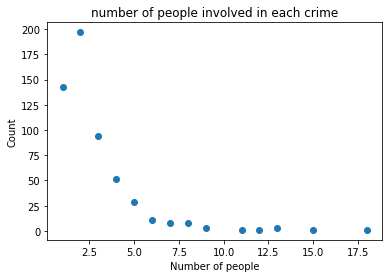

In [19]:
e_p = []
e_c = []
for k in G.nodes():
    if G.nodes[k]["bipartite"] == 0:
        e_p.append(len(G.edges(k)))
    else:
        e_c.append(len(G.edges(k)))

e_cc = Counter(e_c)
plt.scatter(e_cc.keys(), e_cc.values())
plt.title('number of people involved in each crime')
plt.xlabel('Number of people')
plt.ylabel('Count');

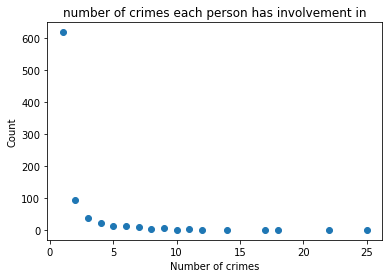

In [20]:
e_pc = Counter(e_p)
plt.scatter(e_pc.keys(), e_pc.values())
plt.title('number of crimes each person has involvement in')
plt.xlabel('Number of crimes')
plt.ylabel('Count');

In [21]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(G) - top_nodes

829


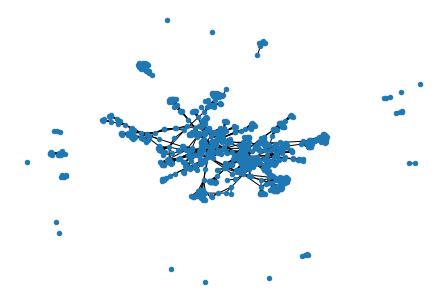

In [22]:
P = bipartite.weighted_projected_graph(G, top_nodes)
print(len(P.nodes()))
nx.draw(P, node_size=20)

551


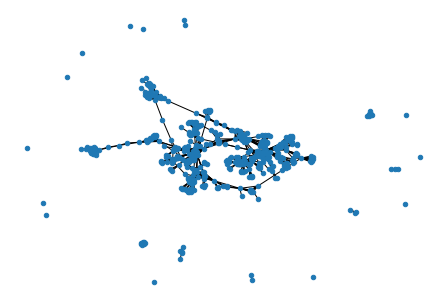

In [23]:
C = bipartite.weighted_projected_graph(G, bottom_nodes)
print(len(C.nodes))
nx.draw(C, node_size=20)

In [24]:
# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])
len(G0.nodes)

1263

In [25]:
top_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes_gcc = set(G0) - top_nodes_gcc

len(top_nodes_gcc), len(bottom_nodes_gcc)

(754, 509)

754


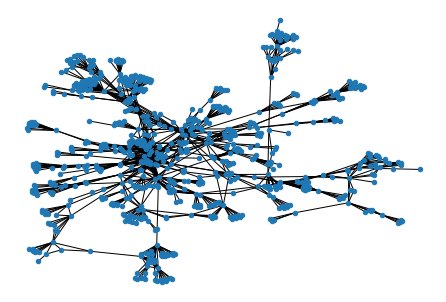

In [26]:
# plot only biggest component
P = bipartite.weighted_projected_graph(G0, top_nodes_gcc)
print(len(P.nodes()))
nx.draw(P, node_size=20)

In [27]:
node_neighbors = {n: len(set(G.neighbors(n))) for n in top_nodes_gcc}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

node_neighbors = {n: len(set(G.neighbors(n))) for n in bottom_nodes_gcc}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

p815 25
110 18


In [28]:
## Seperating layers

victims = [e[0] for e in nx.get_edge_attributes(G0, 'role') if nx.get_edge_attributes(G, 'role')[e] == 'Victim' or  nx.get_edge_attributes(G, 'role')[e] == 'Victim Suspect']
suspects = [e[0] for e in nx.get_edge_attributes(G0, 'role') if nx.get_edge_attributes(G, 'role')[e] == 'Suspect' or  nx.get_edge_attributes(G, 'role')[e] == 'Victim Suspect']
witnesses = [e[0] for e in nx.get_edge_attributes(G0, 'role') if nx.get_edge_attributes(G, 'role')[e] == 'Witness']

In [29]:
print(f'Number of victims {len(victims)}, unique {len(set(victims))}')
print(f'number of suspects {len(suspects)}, unique {len(set(suspects))}')
print(f'number of witnesses {len(witnesses)}, unique {len(set(witnesses))}')
print(f'Total number {len(suspects + witnesses + victims)}, unique {len(set(suspects + witnesses + victims))}')

Number of victims 557, unique 374
number of suspects 680, unique 448
number of witnesses 179, unique 155
Total number 1416, unique 754


In [30]:
other = [e[0] for e in G0.edges() if e[0] not in victims and e[0] not in suspects and e[0] not in witnesses]
         
print(len(other))#sanity check that all people nodes are accounted for

0


In [31]:
v = Counter(victims)
v_top = v.most_common(43) #victim at least 3 times
v_top

[('p815', 11),
 ('p220', 9),
 ('p356', 6),
 ('p404', 6),
 ('p425', 6),
 ('p474', 6),
 ('p497', 6),
 ('p715', 6),
 ('p190', 5),
 ('p549', 5),
 ('p56', 5),
 ('p88', 5),
 ('p10', 4),
 ('p115', 4),
 ('p155', 4),
 ('p2', 4),
 ('p214', 4),
 ('p291', 4),
 ('p336', 4),
 ('p37', 4),
 ('p413', 4),
 ('p414', 4),
 ('p514', 4),
 ('p533', 4),
 ('p592', 4),
 ('p62', 4),
 ('p690', 4),
 ('p696', 4),
 ('p221', 3),
 ('p242', 3),
 ('p277', 3),
 ('p370', 3),
 ('p384', 3),
 ('p452', 3),
 ('p51', 3),
 ('p515', 3),
 ('p572', 3),
 ('p642', 3),
 ('p659', 3),
 ('p729', 3),
 ('p767', 3),
 ('p797', 3),
 ('p811', 3)]

In [32]:
s = Counter(suspects)
s_top = s.most_common(44) #suspect at least 3 times
s_top

[('p2', 17),
 ('p815', 12),
 ('p425', 9),
 ('p695', 9),
 ('p514', 8),
 ('p531', 8),
 ('p220', 6),
 ('p715', 6),
 ('p108', 5),
 ('p56', 5),
 ('p592', 5),
 ('p696', 5),
 ('p74', 5),
 ('p10', 4),
 ('p115', 4),
 ('p356', 4),
 ('p37', 4),
 ('p474', 4),
 ('p51', 4),
 ('p549', 4),
 ('p577', 4),
 ('p659', 4),
 ('p67', 4),
 ('p690', 4),
 ('p729', 4),
 ('p88', 4),
 ('p106', 3),
 ('p128', 3),
 ('p159', 3),
 ('p174', 3),
 ('p303', 3),
 ('p333', 3),
 ('p336', 3),
 ('p384', 3),
 ('p396', 3),
 ('p404', 3),
 ('p410', 3),
 ('p411', 3),
 ('p536', 3),
 ('p572', 3),
 ('p584', 3),
 ('p600', 3),
 ('p663', 3),
 ('p788', 3)]

In [33]:
w = Counter(witnesses)
w.most_common(10)

[('p79', 5),
 ('p56', 4),
 ('p425', 3),
 ('p736', 3),
 ('p112', 2),
 ('p129', 2),
 ('p159', 2),
 ('p17', 2),
 ('p220', 2),
 ('p277', 2)]

In [34]:
def gendercount(node_list, G):
    '''takes a list of nodes with a "sex" attribute, and a graph, G and returns list of (males, females)'''
    female = []
    male = []
    
    for person in node_list:
        if nx.get_node_attributes(G, 'sex')[person] == '0':
            female.append(person)
        else:
            male.append(person)
            
    return male, female

In [35]:
sus = [s[0] for s in s_top]
vic = [v[0] for v in v_top]

vic_sus = [x for x in sus if x in vic]

male, female = gendercount(vic_sus, G)
        
print(f'There are {len(female)} females and {len(male)} males \nwho were victims at least 3 times \nand suspects at least 3 times')

There are 3 females and 21 males 
who were victims at least 3 times 
and suspects at least 3 times


In [36]:
v_male, v_female = gendercount(vic, G)
        
print(f'There are {len(v_female)} females and {len(v_male)} males who were victims at least 3 times')

There are 9 females and 34 males who were victims at least 3 times


In [37]:
s_male, s_female = gendercount(sus, G)
        
print(f'There are {len(s_female)} females and {len(s_male)} males who were suspects at least 3 times')

There are 11 females and 33 males who were suspects at least 3 times


In [38]:
#s_male, s_female

In [39]:
A = {}
for node in top_nodes:
    #print(node)
    A[node] = []
    for edge in G.edges(node):
        try:
            A[node].append(nx.get_edge_attributes(G, 'role')[edge])
            #print(nx.get_edge_attributes(G, 'weight')[edge])
        except: pass

In [40]:
def top(l):
    return Counter(l).most_common()

for a,b in sorted(A.items()):
    print(a, top(b))

p1 [('Suspect', 2), ('Victim', 2)]
p10 [('Suspect', 3), ('Victim', 3), ('Witness', 1), ('Victim Suspect', 1)]
p100 [('Suspect', 1)]
p101 [('Witness', 1), ('Suspect', 1)]
p102 [('Victim', 1)]
p103 [('Witness', 1)]
p104 [('Witness', 1), ('Victim', 1)]
p105 [('Witness', 1)]
p106 [('Suspect', 3)]
p107 [('Witness', 1)]
p108 [('Suspect', 5), ('Victim', 1)]
p109 [('Witness', 1)]
p11 [('Suspect', 1)]
p110 [('Victim', 1)]
p111 [('Suspect', 1)]
p112 [('Witness', 2), ('Suspect', 1), ('Victim', 1)]
p113 [('Suspect', 1)]
p114 [('Suspect', 1), ('Victim', 1)]
p115 [('Victim', 4), ('Suspect', 4), ('Witness', 1)]
p116 [('Victim', 1)]
p117 [('Witness', 1), ('Suspect', 1)]
p118 [('Witness', 1)]
p119 [('Victim', 2)]
p12 [('Victim', 2), ('Witness', 1)]
p120 [('Victim', 1)]
p121 [('Victim', 1)]
p122 [('Suspect', 1)]
p123 [('Suspect', 1)]
p124 [('Suspect', 1)]
p125 [('Victim', 1)]
p126 [('Victim', 1)]
p127 [('Suspect', 1)]
p128 [('Suspect', 3), ('Victim', 2), ('Witness', 1)]
p129 [('Suspect', 2), ('Witness',

In [41]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(G) - top_nodes

P = bipartite.weighted_projected_graph(G, top_nodes)

Pcc = sorted(nx.connected_components(P), key=len, reverse=True)
P0 = P.subgraph(Pcc[0])
len(P0.nodes), len(P0.edges)

(754, 2127)

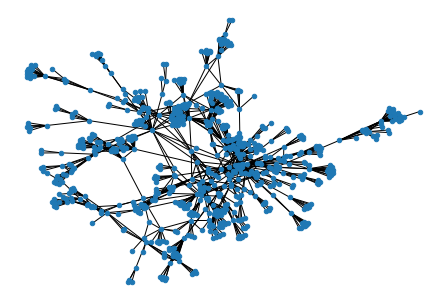

In [42]:
nx.draw_spring(P0, node_size=20)

In [43]:
#P0 = G0

import networkx.algorithms.community as nxcom
communities = sorted(nxcom.greedy_modularity_communities(P0), key=len, reverse=True) #30 coms modularity 0.845
#communities = sorted(nxcom.label_propagation_communities(P0), key=len, reverse=True) #89 coms modularity 0.787

# Count the communities
print(f"There are {len(communities)} communities.")

nxcom.modularity(P0, communities)

There are 30 communities.


0.8451203372057261

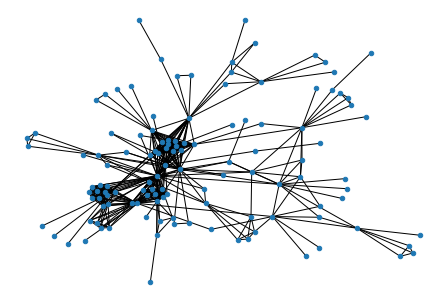

In [44]:
comms = P.subgraph(communities[0])
len(comms.nodes)

nx.draw_spring(comms, node_size=20)

In [45]:
'''Code from: https://orbifold.net/default/community-detection-using-networkx/'''

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b) 

In [46]:
# Set node and edge communities
set_node_community(P0, communities)
set_edge_community(P0)

node_color = [get_color(P0.nodes[v]['community']) for v in P0.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in P0.edges if P0.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in P0.edges if P0.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

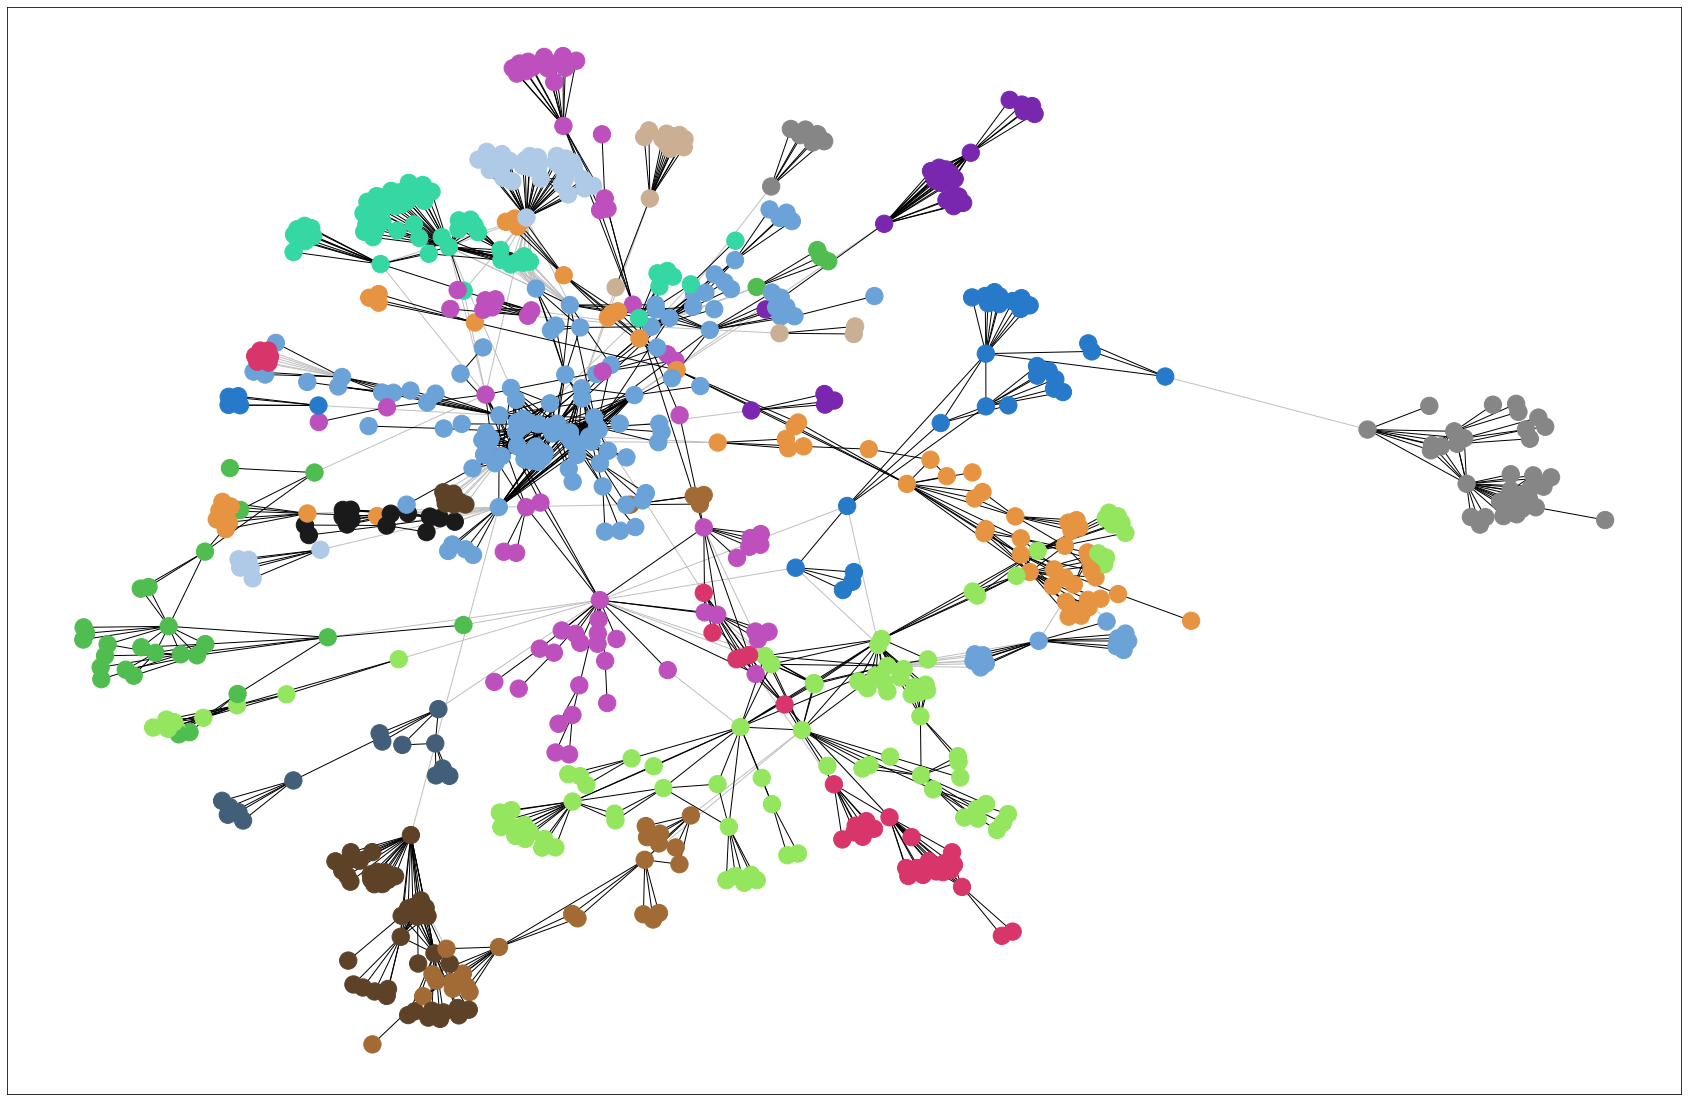

In [47]:
P_pos = nx.spring_layout(P0)

plt.rcParams.update({'figure.figsize': (30, 20)})

# Draw external edges

nx.draw_networkx(
    P0,
    pos=P_pos,
    node_size=5,
    edgelist=external,
    edge_color="silver",
    with_labels=False)

# Draw nodes and internal edges

nx.draw_networkx(
    P0,
    pos=P_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color,
    with_labels=False)



In [48]:
len(set(node_color))

16